<a href="https://colab.research.google.com/github/eduardosci/Analise-_De_Sentimentos_Olist/blob/main/live_proffernanda_nlp_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisando comentários/avaliações do ecommerce (OLIST)


In [54]:
# importando pacote pra manipulação dos dados
import pandas as pd
import string 
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multidict
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

## Importando e explorando a base de dados

In [6]:
# LENDO A BASE DE DADOS EM CSV
# fonte: https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv
reviews = pd.read_csv('/olist_order_reviews_dataset.csv')

In [7]:
# VISUALIZANDO LINHAS E COLUNAS DA TABELA
reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [8]:
# RESUMO DA BASE DE DADOS (QTD LINHAS, COLUNAS, NOMES COLUNAS, VALORES NÃO NULOS...)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


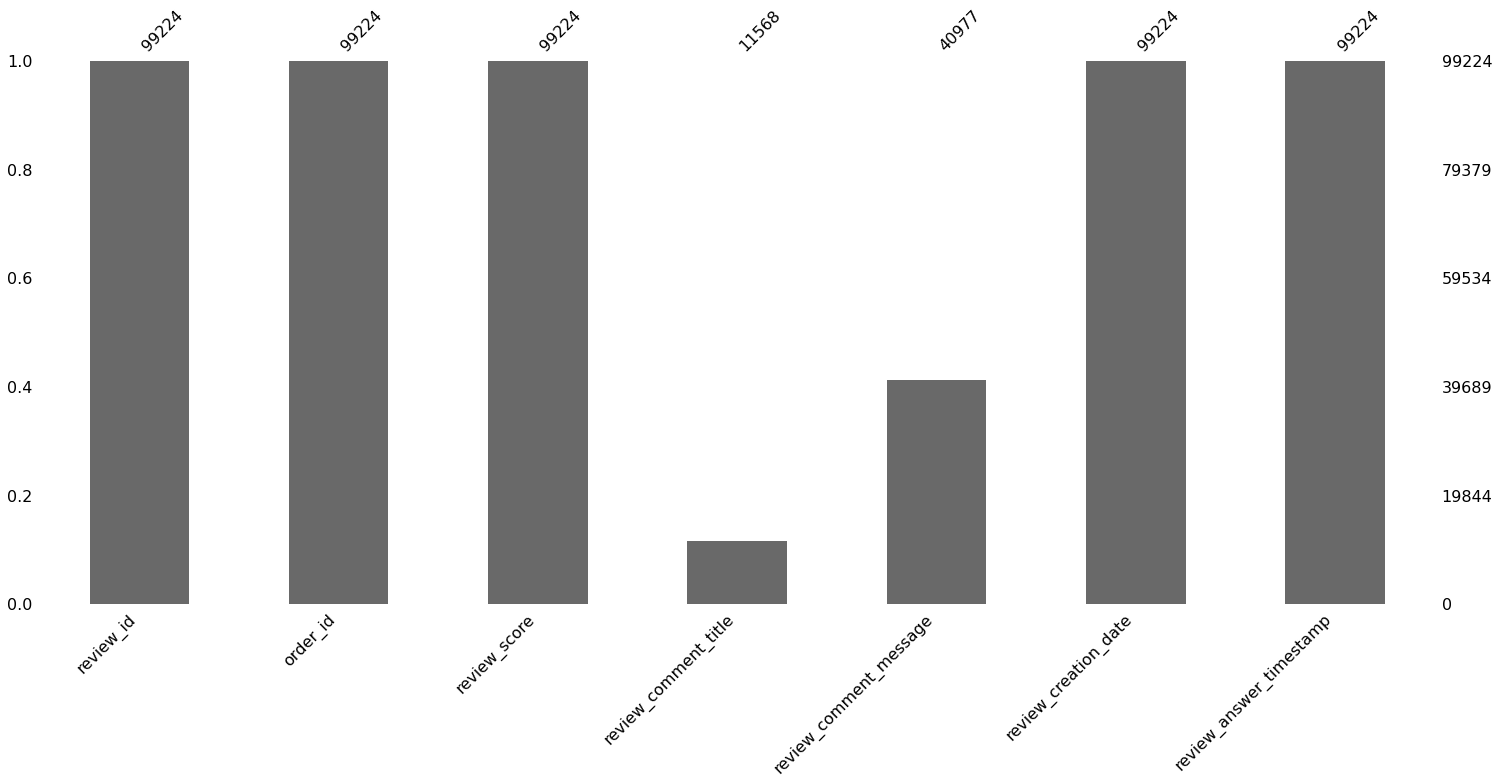

In [12]:
missingno.bar(reviews)

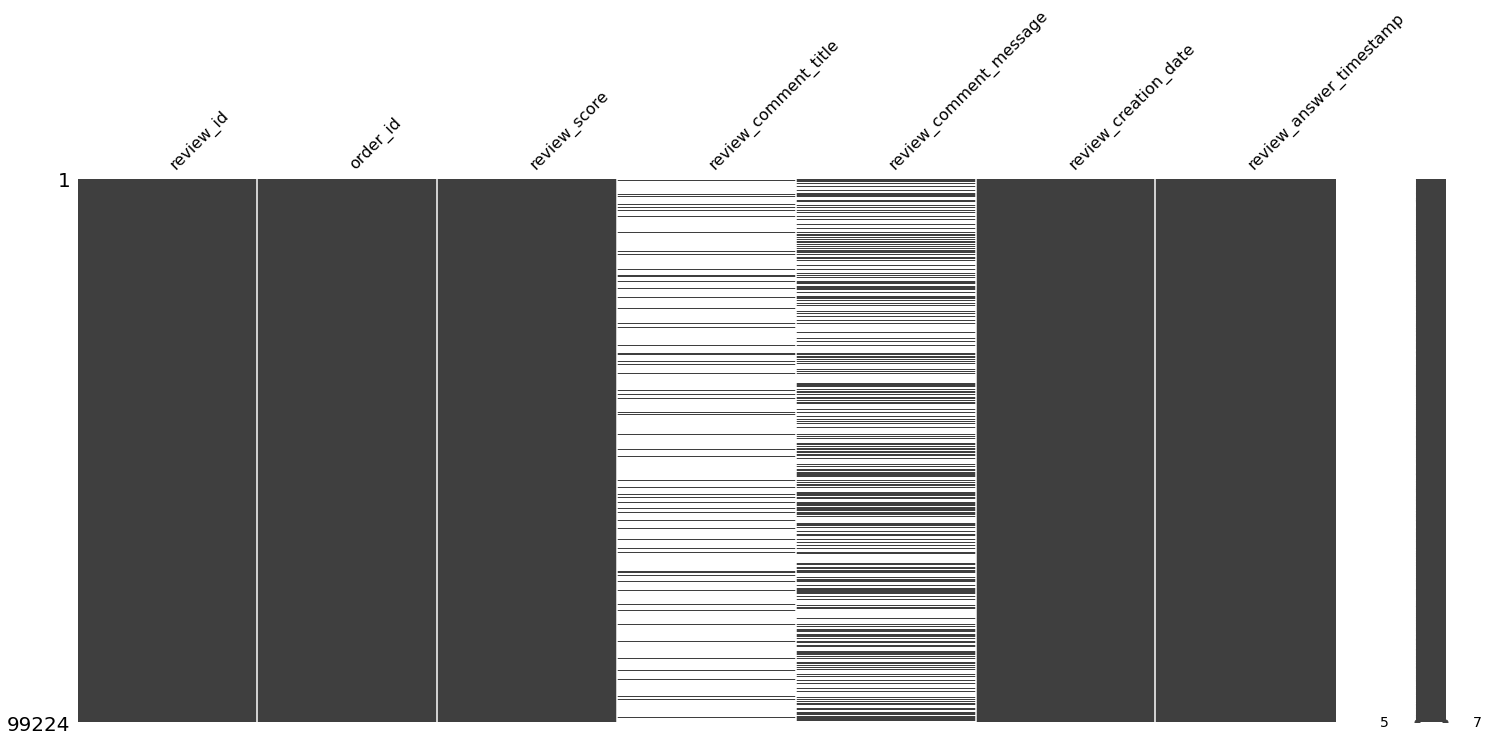

In [13]:
missingno.matrix(reviews)

In [9]:
# CRIANDO NOVO DATAFRAME SOMENTE COM OS COMENTÁRIOS
df_reviews = reviews[['review_comment_message']]

# APAGANDO LINHAS EM BRANCO/NULO
df_reviews  = df_reviews.dropna(subset=['review_comment_message']).reset_index(drop=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40977 entries, 0 to 40976
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_message  40977 non-null  object
dtypes: object(1)
memory usage: 320.3+ KB


## PREPARANDO E TRANSFORMANDO BASE DE DADOS
- padronizando texto (minúsculo)
- remover pontuações
- remover stopwords(palavras sem valor/irrelevantes)
- remover caracteres especiais (emojis, acentuações etc)
- transformando texto (bag of words) matriz de palavras com frequências absolutas

In [10]:
# CONVERTENDO TEXTO PARA MINÚSCULO E SALVANDO EM UMA NOVA COLUNA
df_reviews['comment_clean'] = df_reviews.review_comment_message.str.lower()
df_reviews.head()

review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parabéns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confiável, produto ok e entrega antes...   

                                       comment_clean  
0              recebi bem antes do prazo estipulado.  
1  parabéns lojas lannister adorei comprar pela i...  
2  aparelho eficiente. no site a marca do aparelh...  
3    mas um pouco ,travando...pelo valor ta boa.\r\n  
4  vendedor confiável, produto ok e entrega antes...

In [11]:
# EXCLUINDO PONTUAÇÕES DOS TEXTOS
df_reviews['comment_clean'] = df_reviews.comment_clean.str.translate(str.maketrans(' ', ' ', string.punctuation))
df_reviews.head()

review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parabéns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confiável, produto ok e entrega antes...   

                                       comment_clean  
0               recebi bem antes do prazo estipulado  
1  parabéns lojas lannister adorei comprar pela i...  
2  aparelho eficiente no site a marca do aparelho...  
3         mas um pouco travandopelo valor ta boa\r\n  
4  vendedor confiável produto ok e entrega antes ...

In [12]:
# REMOVENDO ACENTUAÇÕES 
df_reviews['comment_clean'] = df_reviews.comment_clean.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_reviews.head()

review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parabéns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confiável, produto ok e entrega antes...   

                                       comment_clean  
0               recebi bem antes do prazo estipulado  
1  parabens lojas lannister adorei comprar pela i...  
2  aparelho eficiente no site a marca do aparelho...  
3         mas um pouco travandopelo valor ta boa\r\n  
4  vendedor confiavel produto ok e entrega antes ...

In [13]:
# MATRIZ "BAG OF WORD"
vectorizer = CountVectorizer()
matrix_words = vectorizer.fit_transform(df_reviews.comment_clean)

In [22]:
# VISUALIZANDO A MATRIZ
matrix_words.toarray()[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# SOMANDO A FREQUENCIA DE CADA PALAVRA
freq_words = matrix_words.toarray().sum(axis=0)
words = vectorizer.get_feature_names()

words[:5],freq_words[:5]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(['00', '000580', '001063', '001689', '003566'], array([2, 1, 1, 2, 1]))

In [16]:
# CONVERTENDO MATRIZ PARA UM DATAFRAME COM FREQUENCIA ABSOLUTA
df_freq_words = pd.DataFrame({'palavra':words,'freq':freq_words})
df_freq_words

palavra  freq
0          00     2
1      000580     1
2      001063     1
3      001689     2
4      003566     1
...       ...   ...
18365    zoom     4
18366   zuado     1
18367   zufer     1
18368   zumax     1
18369   zupin     1

[18370 rows x 2 columns]

In [17]:
# ORDENANDO LINHAS PELA COLUNA "FREQ"
df_freq_words = df_freq_words.sort_values('freq',ascending=False)
df_freq_words

palavra   freq
14299         produto  18161
12006             nao  12066
5685               de  11311
6629               do  11144
14754             que   8322
...               ...    ...
7631       escolhidoo      1
7632   escolhidoquero      1
7633         escondem      1
7634        escondido      1
18369           zupin      1

[18370 rows x 2 columns]

In [19]:
# BAIXANDO BASE DE DADOS COM STOPWORDS
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# CARREGANDO STOPWORDS EM PORTUGUES
stopwords_pt = stopwords.words("portuguese")
stopwords_pt.remove('não')
stopwords_pt[:10]

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

In [22]:
# RETIRAR ACENTUAÇÕES DAS STOPWORDS
stopwords_pt = list(pd.Series(stopwords_pt).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
stopwords_pt[:10]

['de', 'a', 'o', 'que', 'e', 'e', 'do', 'da', 'em', 'um']

In [23]:
# LOOP PARA PERCORRER CADA LINHA DE COMENTÁRIO PARA REMOVER OS STOPWORDS
text_clean = []
for text in df_reviews.comment_clean:
  t = ' '.join([word for word in text.split() if word not in stopwords_pt])
  text_clean.append(t)

text_clean[:5]

['recebi bem antes prazo estipulado',
 'parabens lojas lannister adorei comprar internet seguro pratico parabens todos feliz pascoa',
 'aparelho eficiente site marca aparelho impresso 3desinfector chegar outro nomeatualizar marca correta vez aparelho',
 'pouco travandopelo valor ta boa',
 'vendedor confiavel produto ok entrega antes prazo']

In [24]:
# INSERINDO TEXTO SEM STOPWORDS(CÉLULA ANTERIOR) NA COLUNA DO DATAFRAME
df_reviews['comment_clean'] = text_clean
df_reviews.head(5)

review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parabéns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confiável, produto ok e entrega antes...   

                                       comment_clean  
0                  recebi bem antes prazo estipulado  
1  parabens lojas lannister adorei comprar intern...  
2  aparelho eficiente site marca aparelho impress...  
3                    pouco travandopelo valor ta boa  
4  vendedor confiavel produto ok entrega antes prazo

In [25]:
# REFAZENDO A MATRIZ "BAG OF WORD" COM OS NOVOS COMENTÁRIO
vectorizer = CountVectorizer() 
matrix_words = vectorizer.fit_transform(df_reviews.comment_clean)

freq_words = matrix_words.toarray().sum(axis=0)
words = vectorizer.get_feature_names()

df_freq_words = pd.DataFrame({'palavra':words,'freq':freq_words})
df_freq_words = df_freq_words.sort_values('freq',ascending=False)
df_freq_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


palavra   freq
14202          produto  18161
11927              nao  12066
13747            prazo   8262
7322           entrega   6413
2222             antes   5610
...                ...    ...
7568               esa      1
7569          esbarrao      1
7572         escalacao      1
7573   escandalosapois      1
18222            zupin      1

[18223 rows x 2 columns]

# Excluindo stopwords especificas

In [26]:
stopwords_pt = stopwords.words("portuguese")
stopwords_pt.remove('não')
## adicionando novas palavras específicas na lista de stopwords
stopwords_pt.extend(['ünica','especificaçãodentro','especificaçao'])

text_clean = []
for text in df_reviews.comment_clean:
  t = ' '.join([word for word in text.split() if word not in stopwords_pt])
  text_clean.append(t)

df_reviews['comment_clean'] = text_clean

In [27]:
# REFAZENDO A MATRIZ "BAG OF WORD" COM OS NOVOS COMENTÁRIOS
vectorizer = CountVectorizer()#ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
matrix_words = vectorizer.fit_transform(df_reviews.comment_clean)

freq_words = matrix_words.toarray().sum(axis=0)
words = vectorizer.get_feature_names()

df_freq_words = pd.DataFrame({'palavra':words,'freq':freq_words})
df_freq_words = df_freq_words.sort_values('freq',ascending=False)
df_freq_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


palavra   freq
14202          produto  18161
11927              nao  12066
13747            prazo   8262
7322           entrega   6413
2222             antes   5610
...                ...    ...
7568               esa      1
7569          esbarrao      1
7572         escalacao      1
7573   escandalosapois      1
18222            zupin      1

[18223 rows x 2 columns]

## VISUALIZAÇÃO DOS RESULTADOS
- gráfico de barra
- wordcloud

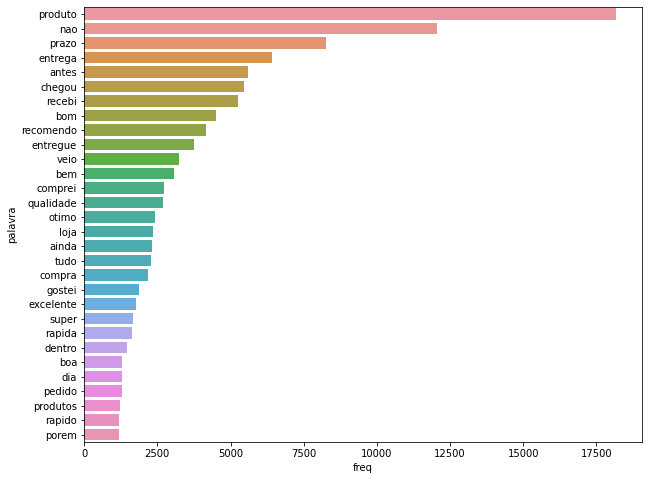

In [29]:
# GRÁFICO DE BARRA HORIZONTAL
plt.figure(figsize=(10,8))
sns.barplot(x='freq',y='palavra',data=df_freq_words.iloc[:30,:])
plt.show()

In [30]:
# CONCATENANDO TODOS OS COMENTÁRIOS EM UMA VARIÁVEL
todos_comentarios = ' '.join(df_reviews.comment_clean)
todos_comentarios

'recebi bem antes prazo estipulado parabens lojas lannister adorei comprar internet seguro pratico parabens todos feliz pascoa aparelho eficiente site marca aparelho impresso 3desinfector chegar outro nomeatualizar marca correta vez aparelho pouco travandopelo valor ta boa vendedor confiavel produto ok entrega antes prazo gostaria saber sempre recebi compra agora decpcionou pessimo loja nota 10 obrigado atencao amim dispensada compra realizada facilmente entrega efetuada antes prazo dado produto comecou ser usado presente problemas relogio bonito barato nao gostei comprei gato lebre sempre compro internet entrega ocorre antes prazo combinado acredito ser prazo maximo stark prazo maximo esgotou ainda nao recebi produto recebi exatamente esperava demais encomendas outros vendedores atrasaram chegou prazo recomendo boa to completamente apaixonada loja super responsavel confiavel nada chegar pedido bom cheiroso otimo vendedor chegou antes prazo adorei produto processo compra tranquilo efic

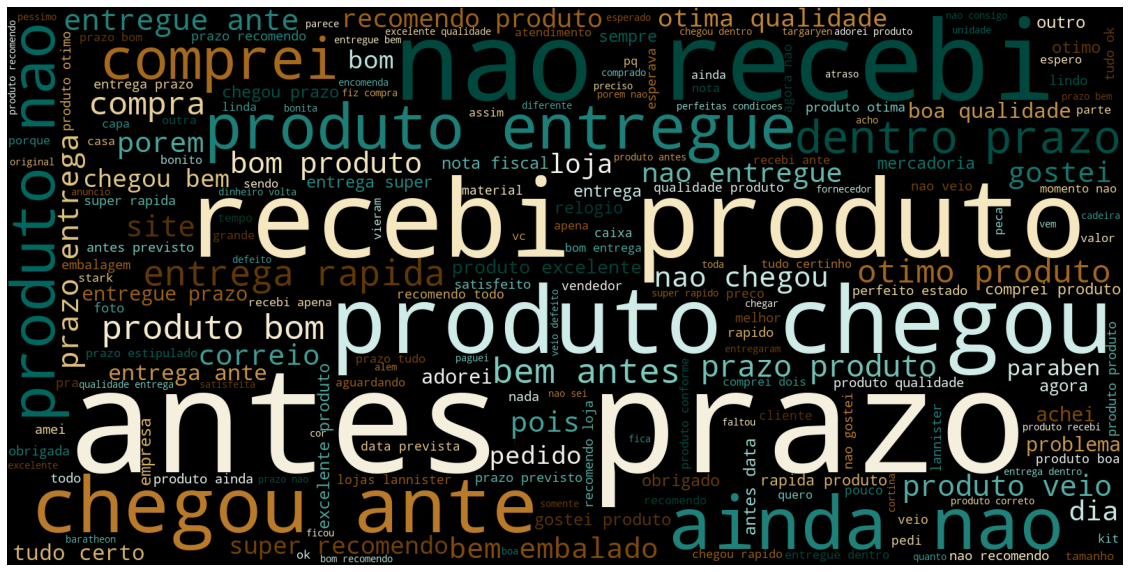

In [32]:
# FAZENDO WORDCLOUD
wordcloud = WordCloud(width=1600, height=800,random_state=42,background_color='black',colormap='BrBG_r').generate(todos_comentarios)

fig, ax = plt.subplots(figsize=(20,15))
ax.imshow(wordcloud)#, interpolation='bilinear')
ax.set_axis_off()

# ANÁLISE PALAVRAS DUPLAS (TRIGRAM - 3 palavras)


In [43]:
df_reviews['comment_clean'] = df_reviews.review_comment_message.str.lower() #padronizar minúsculo
df_reviews['comment_clean'] = df_reviews.comment_clean.str.translate(str.maketrans(' ', ' ', string.punctuation)) #remover pontuação
df_reviews['comment_clean'] = df_reviews.comment_clean.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8') #remover acentuação

stopwords_pt = stopwords.words("portuguese")
stopwords_pt.remove('não') # essa stopwords é extreamente importante para essa análise, por isso foi removida
stopwords_pt = pd.Series(stopwords_pt).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

text_clean = []
for text in df_reviews.comment_clean:
  t = ' '.join([word for word in text.split() if word not in stopwords_pt])
  text_clean.append(t)

df_reviews['comment_clean'] = text_clean

In [44]:
# REFAZENDO A MATRIZ "BAG OF WORD" COM TRI-GRAM
vectorizer_trigram = CountVectorizer(ngram_range=(3, 3),min_df=2)
matrix_trigram = vectorizer_trigram.fit_transform(df_reviews.comment_clean)

freq_trigram = matrix_trigram.toarray().sum(axis=0)
trigram = vectorizer_trigram.get_feature_names()

matrix_trigram.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(40977, 28302)

In [45]:
df_freq_trigram = pd.DataFrame({'palavra':trigram,'freq':freq_trigram})
df_freq_trigram = df_freq_trigram.sort_values('freq',ascending=False)
df_freq_trigram

palavra  freq
851                antes do prazo  4012
2730              chegou antes do  1199
6578              dentro do prazo  1046
1671                 bem antes do   850
16102          nao recebi produto   815
...                           ...   ...
12171  informacoes corretas sobre     2
12170       informacoes acerca da     2
12168     informacao sobre pedido     2
12166     informacao sobre atraso     2
28301                 xl preto hp     2

[28302 rows x 2 columns]

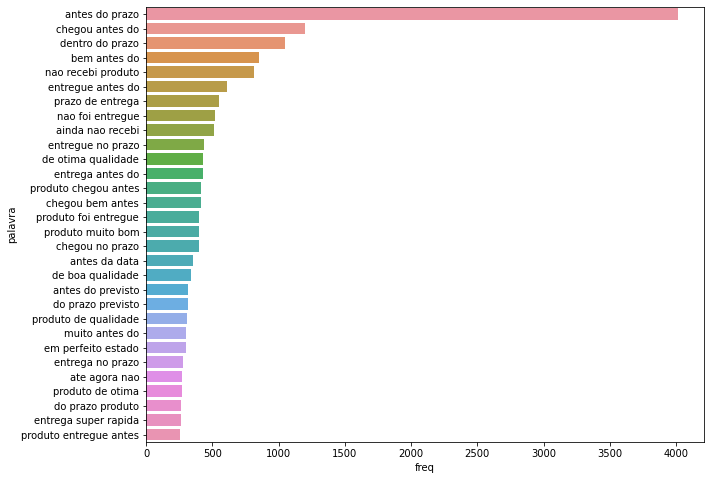

In [46]:
# GRÁFICO DE BARRA HORIZONTAL
plt.figure(figsize=(10,8))
sns.barplot(x='freq',y='palavra',data=df_freq_trigram.iloc[:30,:])
plt.show()

In [47]:
# CONVERTENDO DATAFRAME PARA MULTIDICT. REQUISITO DO PACOTE PARA TRABALHAR COM FREQUENCIAS
freq_trigram = multidict.MultiDict()
for x in df_freq_trigram.itertuples():
  freq_trigram.add(x.palavra,x.freq)

freq_trigram

<MultiDict('antes do prazo': 4012, 'chegou antes do': 1199, 'dentro do prazo': 1046, 'bem antes do': 850, 'nao recebi produto': 815, 'entregue antes do': 608, 'prazo de entrega': 551, 'nao foi entregue': 523, 'ainda nao recebi': 513, 'entregue no prazo': 433, 'de otima qualidade': 432, 'entrega antes do': 427, 'produto chegou antes': 413, 'chegou bem antes': 410, 'produto foi entregue': 402, 'produto muito bom': 400, 'chegou no prazo': 396, 'antes da data': 357, 'de boa qualidade': 337, 'antes do previsto': 317, 'do prazo previsto': 312, 'produto de qualidade': 310, 'muito antes do': 300, 'em perfeito estado': 298, 'entrega no prazo': 275, 'ate agora nao': 271, 'produto de otima': 268, 'do prazo produto': 266, 'entrega super rapida': 264, 'produto entregue antes': 255, 'produto nao foi': 247, 'nao recebi meu': 234, 'recebi meu produto': 231, 'entregue dentro do': 227, 'gostei do produto': 222, 'do prazo estipulado': 215, 'da data prevista': 215, 'produto de boa': 202, 'em perfeitas con

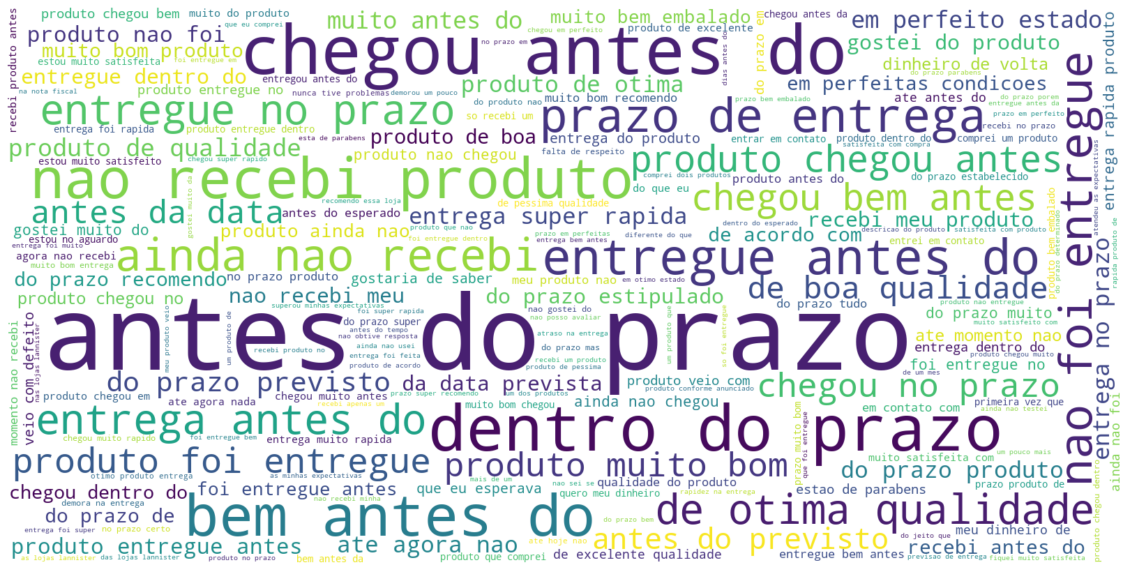

In [48]:
# FAZENDO WORDCLOUD COM DICIONÁRIO DE FREQUENCIA
wordcloud = WordCloud(width=1600, height=800,random_state=42,background_color='white').generate_from_frequencies(freq_trigram)

fig, ax = plt.subplots(figsize=(20,13))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()